Для визуализации "внимания" модели в архитектурах, где нет явного слоя внимания, лучше всего подходит метод карт значимости (Saliency Maps), основанный на градиентах.

### Концепция: Карта Значимости
Идея очень проста и элегантна: чтобы понять, какие части входного сигнала были важны для получения конечного результата (эмбеддинга), мы можем задать вопрос:

> "Если я немного изменю значение сигнала в конкретной временной точке t, насколько сильно изменится итоговый эмбеддинг?"

Ответ на этот вопрос дает градиент выхода (эмбеддинга) по отношению ко входу (сигналу).

Большой градиент в точке t означает, что эта точка очень важна. Небольшое изменение здесь сильно влияет на результат.
Маленький (нулевой) градиент означает, что эта точка практически не повлияла на решение модели.
Таким образом, рассчитав модуль градиента для каждой точки входного ряда, мы получим "карту", которая подсвечивает наиболее важные для модели участки.

### Архитектурная Особенность  Модели
В  HierarchicalSignalNet итоговый эмбеддинг формируется на основе последнего скрытого состояния GRU, которое, в свою очередь, является агрегацией информации со всей последовательности. Метод карт значимости идеально подходит для того, чтобы "распаковать" эту агрегацию и посмотреть, какие входные точки внесли наибольший вклад в финальное состояние.

Пошаговая Реализация
Давайте напишем код, который сгенерирует и визуализирует карту значимости для любого заданного сигнала.

Шаг 1: Функция для генерации карты значимости
Нам понадобится функция, которая будет выполнять следующие действия:

1. Принимать на вход модель и один сигнал.
2. Включать расчет градиентов для входного тензора.
3. Делать прямой проход (forward pass).
4. Вычислять скалярное значение из выходного эмбеддинга (например, сумму его элементов), так как обратное распространение ошибки (backward()) можно вызвать только для скаляра.
5. Запускать обратное распространение ошибки для вычисления градиентов.
6. Возвращать модуль полученных градиентов.

In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
module_path = os.path.abspath(os.path.join('..'))  
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
from src.model.siam import HierarchicalSignalNet
from src.dataloader.dataloader import SignalDataset, create_dummy_data

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


c:\Users\mind7\projects\siam_timeseries
Используемое устройство: cpu


In [2]:
def generate_saliency_map(model, signal_tensor, device):
    """
    Генерирует карту значимости для многоканального сигнала.
    Предполагает, что signal_tensor имеет форму (seq_len, channels).
    """
    model.eval()
    
    # --- ШАГ 1: КОРРЕКТНОЕ ПРЕОБРАЗОВАНИЕ ВХОДА ---
    # Исходная форма: (seq_len, channels), например (1000, 2)
    # 1. Меняем оси местами -> (channels, seq_len), например (2, 1000)
    # 2. Добавляем batch-размерность -> (batch, channels, seq_len), например (1, 2, 1000)
    input_tensor = signal_tensor.clone().detach().permute(1, 0).unsqueeze(0).to(device)
    input_tensor.requires_grad_()
    
    print(f"Форма тензора на входе в модель: {input_tensor.size()}") # Ожидаем (1, 2, 1000)
    
    # Прямой проход
    # Убедитесь, что ваша модель возвращает (embedding, ...)
    embedding, _ = model(input_tensor) 
    
    # Скаляр для обратного прохода
    scalar_output = embedding.sum()
    
    # Вычисление градиентов
    model.zero_grad()
    scalar_output.backward()
    
    # --- ШАГ 2: АГРЕГАЦИЯ ГРАДИЕНТОВ ПО КАНАЛАМ ---
    # input_tensor.grad будет иметь форму (1, channels, seq_len)
    # Берем абсолютное значение градиента
    abs_grad = input_tensor.grad.data.abs()
    
    # Усредняем градиенты по оси каналов (dim=1)
    # (1, 2, 1000) -> (1, 1000)
    saliency = abs_grad.mean(dim=1)
    
    # Убираем лишние размерности и переводим в numpy
    saliency = saliency.squeeze().cpu().numpy()
    
    # Диагностика
    print("\n--- Диагностика карты значимости ---")
    if saliency is not None and saliency.size > 0:
        print(f"Размер итоговой карты: {saliency.shape}") # Ожидаем (1000,)
        print(f"Максимум карты: {saliency.max()}")
        if saliency.max() == saliency.min():
            print("ПРЕДУПРЕЖДЕНИЕ: Карта значимости состоит из одинаковых значений!")
    else:
        print("ОШИБКА: Карта значимости пуста!")
    print("------------------------------------\n")

    return saliency

# Функция визуализации остается той же, но теперь ей на вход нужно подавать 
# один из каналов исходного сигнала для отрисовки.
def visualize_saliency(original_signal_channel, saliency_map, channel_index=0, title="Карта значимости (Saliency Map)"):
    """
    Визуализирует один канал исходного сигнала и подсвечивает его картой значимости.
    """
    if saliency_map.max() <= saliency_map.min():
        print("Визуализация пропущена: карта значимости пуста или имеет нулевой диапазон.")
        return

    # Код визуализации без изменений...
    saliency_map_normalized = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.plot(original_signal_channel, color='royalblue', label=f'Исходный сигнал (канал {channel_index})')
    cmap = LinearSegmentedColormap.from_list("saliency_cmap", ["#FFFFFF00", "red"])
    x_coords = np.arange(len(original_signal_channel))
    saliency_grid = np.tile(saliency_map_normalized, (100, 1))
    im = ax.imshow(saliency_grid, aspect='auto', cmap=cmap, 
                   extent=[x_coords[0]-0.5, x_coords[-1]+0.5, ax.get_ylim()[0], ax.get_ylim()[1]],
                   alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel("Временные отсчеты")
    ax.set_ylabel("Амплитуда")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

Генерация фиктивных данных...
Сгенерировано 1 сигналов.
torch.Size([1000, 2])
Форма тензора на входе в модель: torch.Size([1, 2, 1000])

--- Диагностика карты значимости ---
Размер итоговой карты: (1000,)
Максимум карты: 0.023857630789279938
------------------------------------



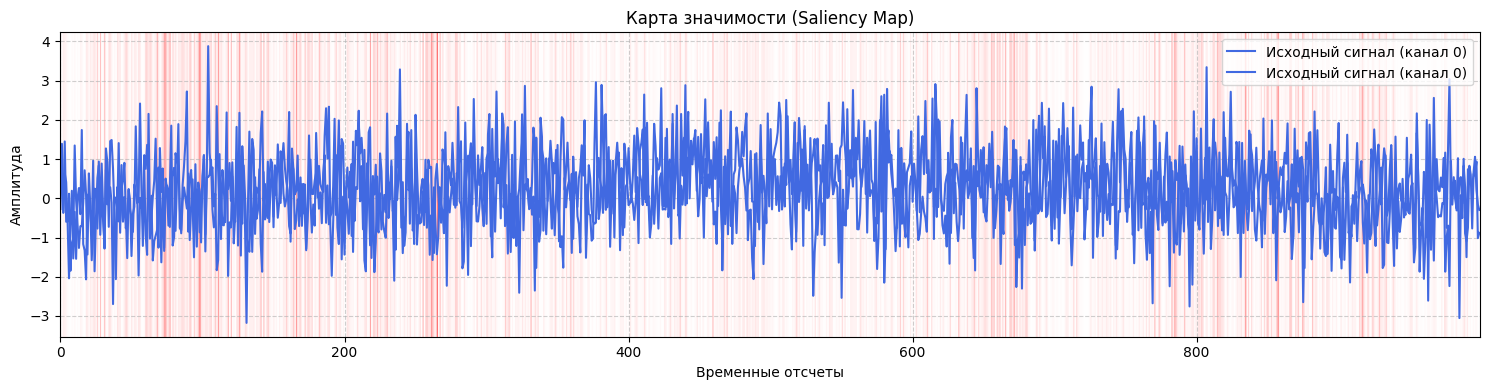

In [3]:
# --- 1. Загрузка модели и данных ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EMBEDDING_DIM = 64
model = HierarchicalSignalNet(embedding_dim=EMBEDDING_DIM)
# Укажите путь к вашим обученным весам!
try:
    model.load_state_dict(torch.load("../checkpoints/model_epoch_20.pth")) 
except FileNotFoundError:
    print("Внимание: Файл с весами модели не найден. Будут использованы случайные веса.")
    # Если веса не найдены, код все равно отработает, но карта будет бессмысленной
model.to(DEVICE)


# --- 2. Возьмем один пример для анализа ---
# Можно взять из валидационного набора или сгенерировать новый
signals, _, _, _ = create_dummy_data(1, 1, 1)
example_signal_np = signals[0]
example_signal_tensor = torch.tensor(example_signal_np, dtype=torch.float32)
print(example_signal_tensor.size())
# --- 3. Генерация и визуализация карты значимости ---
saliency_map = generate_saliency_map(model, example_signal_tensor, DEVICE)

visualize_saliency(example_signal_np, saliency_map)

### Как Интерпретировать Результат
На полученном графике вы увидите:

**Синюю** линию — это ваш исходный временной ряд.
**Красную** подсветку на фоне — это и есть карта значимости.
**Яркие красные области** — это те участки сигнала, на которые модель "смотрела" наиболее пристально при формировании его эмбеддинга. Это могут быть резкие пики, спады, начало или конец какого-то характерного паттерна — именно те признаки, которые модель научилась считать важными для различения сессий и элементов.

Этот метод является мощным инструментом для отладки и анализа, позволяя убедиться, что модель учится осмысленным вещам, а не просто опирается на случайные артефакты в данных.